# Airport Traffic Visualization geopandas & Plotly✈



In [1]:
from datetime import date
import os

import geopandas as gpd
import geoplot as gplt
import folium
import mapclassify
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import re
import seaborn as sns
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon



In [2]:
%matplotlib inline

In [3]:
!ls ../input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv

../input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv


In [4]:
covid_impact_on_airport_traffic = pd.read_csv("../input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv")

In [5]:
covid_impact_on_airport_traffic.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


 there are 11 columns.

- AggregationMethod: Aggregation period used to compute this metric

- Date: Date Traffic volume measured, in format YYYY-MM-DD.

- Version: Version of this dataset

- AirportName: Name of airport

- PercentOfBaseline: Proportion of trips on this date as compared to Avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020

- Centroid: Geography representing centroid of the Airport polygon

- City: City within which the Airport is located

- State: State within which the Airport is located

- ISO_3166_2: ISO-3166-2 code representing Country and Subdivision

- Country: Country within which the Airport is located

- Geography: Polygon of the Airport that is used to compute this metric

In [6]:
covid_impact_on_airport_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AggregationMethod  7247 non-null   object 
 1   Date               7247 non-null   object 
 2   Version            7247 non-null   float64
 3   AirportName        7247 non-null   object 
 4   PercentOfBaseline  7247 non-null   int64  
 5   Centroid           7247 non-null   object 
 6   City               7247 non-null   object 
 7   State              7247 non-null   object 
 8   ISO_3166_2         7247 non-null   object 
 9   Country            7247 non-null   object 
 10  Geography          7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


There are no null data.

<a id="2"></a> <br>
# <div class="alert alert-block alert-info">Preprocessing</div>

In [7]:
covid_impact_on_airport_traffic["Date"] = covid_impact_on_airport_traffic["Date"].map(lambda x: date.fromisoformat(x))

And I'll create "weekday" columns. date.weekday() returns 0 for Monday and 6 for Sunday.

With list of Weekday string, we can get weekday columns which has each weekday string.

In [8]:
covid_impact_on_airport_traffic["weekday"] = covid_impact_on_airport_traffic["Date"].map(lambda x: x.weekday())
w_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
covid_impact_on_airport_traffic["weekday"] = [w_list[idx] for idx in covid_impact_on_airport_traffic["weekday"]]

Next, I'll create Latitude and longitude columns. Centroid column has Latitude and longitude data as Point object, but it seems to be string. So, I'll cut out Latitude and longitude.

In [9]:
def cut_long(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    long, _ = point[6:-1].split(" ")
    return float(long)

def cut_lat(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    _, lat = point[6:-1].split(" ")
    return float(lat)

In [10]:
covid_impact_on_airport_traffic["long"] = covid_impact_on_airport_traffic["Centroid"].map(cut_long)
covid_impact_on_airport_traffic["lat"] = covid_impact_on_airport_traffic["Centroid"].map(cut_lat)

Drop unnecessary columns.

In [11]:
need_columns = [col for col in covid_impact_on_airport_traffic.columns if not col in ["AggregationMethod", "Version", "Centroid"]]
covid_impact_on_airport_traffic = covid_impact_on_airport_traffic[need_columns]

In [12]:
covid_impact_on_airport_traffic.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-04-13,Kingsford Smith,29,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Mon,151.180088,-33.945977
2,2020-07-10,Kingsford Smith,54,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
3,2020-09-02,Kingsford Smith,18,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Wed,151.180088,-33.945977
4,2020-10-31,Kingsford Smith,22,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Sat,151.180088,-33.945977


In addition, I'll create a supplementary data frame.

First, a data frame that makes the airport name unique. We can easily see data for each airport. and I'll use it later when we plot it with folium. 

In [13]:
covid_impact_on_airport_traffic_unique = covid_impact_on_airport_traffic[~covid_impact_on_airport_traffic[["AirportName"]].duplicated()].reset_index(drop=True)
covid_impact_on_airport_traffic_unique

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-03-17,Santiago International Airport,72,Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ...",Tue,-70.794237,-33.390727
2,2020-04-05,Calgary International,65,Calgary,Alberta,CA-AB,Canada,"POLYGON((-113.981866836548 51.1392131913567, -...",Sun,-114.013123,51.118475
3,2020-04-20,Edmonton International,46,Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -...",Mon,-113.576261,53.308783
4,2020-05-15,Vancouver International,68,Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -...",Fri,-123.177541,49.193579
5,2020-05-27,Winnipeg International,100,Winnipeg,Manitoba,CA-MB,Canada,"POLYGON((-97.2094345092773 49.8979517850609, -...",Wed,-97.219062,49.902471
6,2020-03-29,Halifax International,32,Halifax,Nova Scotia,CA-NS,Canada,"POLYGON((-63.5266613960266 44.8984438169036, -...",Sun,-63.511672,44.883017
7,2020-04-10,Toronto Pearson,10,Mississauga,Ontario,CA-ON,Canada,"POLYGON((-79.6076846122742 43.6972621366144, -...",Fri,-79.631344,43.679352
8,2020-08-10,Hamilton International,100,Hamilton,Ontario,CA-ON,Canada,"POLYGON((-79.932746887207 43.1551600161937, -7...",Mon,-79.926693,43.172036
9,2020-09-16,Montreal Mirabel,100,Mirabel,Quebec,CA-QC,Canada,"POLYGON((-74.0895652770996 45.6856314730097, -...",Wed,-74.048380,45.681503


Next, geometry dataframe which key is airport name.

In [14]:
df_geometry = covid_impact_on_airport_traffic_unique[['AirportName', 'City', 'State',
                                                     'ISO_3166_2', 'Country', 'long', 'lat']]

<a id="3"></a> <br>
# <div class="alert alert-block alert-info">Data overview</div>

I'll find out where the airport is located. With folium, we can check the location on interactive map.

In [15]:
def visualize_airport_map(df,  zoom):
    
    lat_map=30.038557
    lon_map=31.231781
    f = folium.Figure(width=1000, height=500)
    m = folium.Map([lat_map,lon_map], zoom_start=zoom).add_to(f)
        
    for i in range(0,len(df)):
        folium.Marker(location=[df["lat"][i],df["long"][i]],icon=folium.Icon(icon_color='white',icon ='plane',prefix='fa')).add_to(m)
        
    return m

In [16]:
visualize_airport_map(covid_impact_on_airport_traffic_unique, 1)

Most of them are in North America.

Also you can easily look up the name and geographic information of the area where the airport is located.

Let's check out the pie chart to see how many records there are for each country.

Text(0.5, 1.0, 'records for each country')

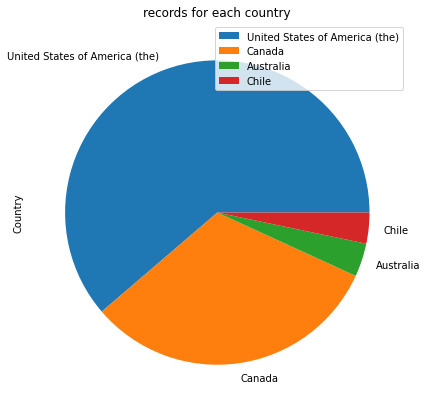

In [17]:
df_Country_count = pd.DataFrame(covid_impact_on_airport_traffic["Country"].value_counts())
#df_Country_count
g = df_Country_count.plot.pie(y='Country', figsize=(7, 7))
g.set_title("records for each country")

Most of them are also in North America. In particular, The U.S. accounted for more than half of the total.

Let's also count the number of records per airport. The number of records at each airport is roughly the same.

Text(0.5, 1.0, 'records for each airport')

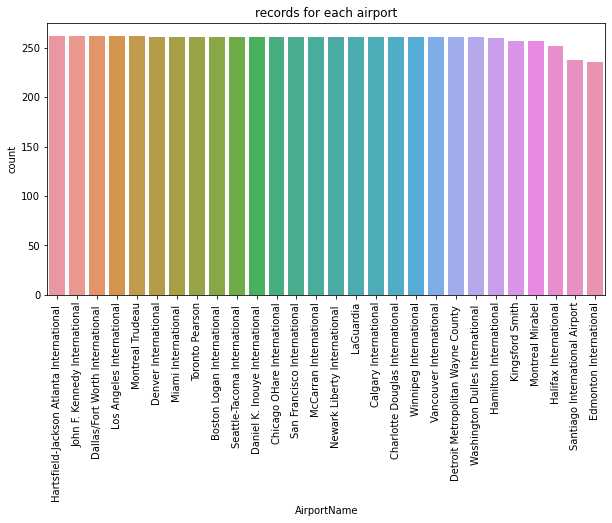

In [18]:
plt.figure(figsize=(10, 5))
g = sns.countplot(data=covid_impact_on_airport_traffic, x="AirportName",
              order = covid_impact_on_airport_traffic['AirportName'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("records for each airport")

Let's also count the number of records per month. The numbers of records between April to September are roughly the same, but March and October are less.

Text(0.5, 1.0, 'records for each month')

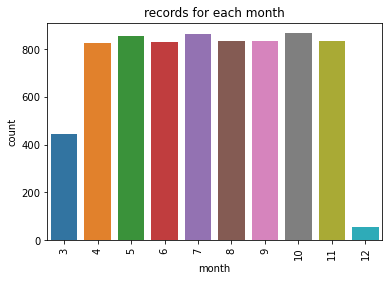

In [19]:
df_month_count = pd.DataFrame(covid_impact_on_airport_traffic["Date"].map(lambda d: d.month).value_counts())
df_month_count = df_month_count.reset_index()
df_month_count = df_month_count.rename(columns={"Date":"count", "index":"month"})
g = sns.barplot(data=df_month_count.reset_index(), y="count", x="month")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("records for each month")

Finally, check the weekday rates. If you look at the pie chart, you can see that it is roughly the same

Text(0.5, 1.0, 'records for each weekday')

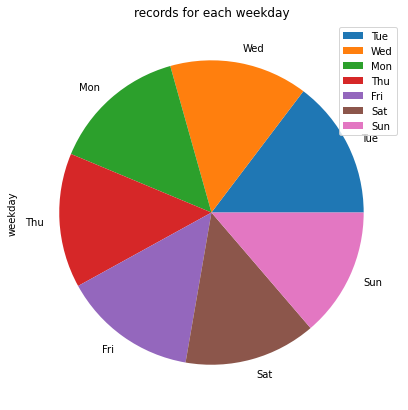

In [20]:
df_weekday_count = pd.DataFrame(covid_impact_on_airport_traffic["weekday"].value_counts())
g = df_weekday_count.plot.pie(y='weekday', figsize=(7, 7))
g.set_title("records for each weekday")

<a id="4"></a> <br>
# <div class="alert alert-block alert-info">How to visualization with geopandas?</div>

Next, I'll plot data to world map by geopandas.

For mapping with geopandas, [this page](https://geopandas.org/mapping.html) is helpful.

First, I'll create GeoDataFrame. When create, we can create a column of Point instances by specifying "geometry" argument.

In [21]:
gdf = gpd.GeoDataFrame(covid_impact_on_airport_traffic_unique, 
                       geometry=gpd.points_from_xy(covid_impact_on_airport_traffic_unique.long, covid_impact_on_airport_traffic_unique.lat))

In [22]:
gdf.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat,geometry
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977,POINT (151.18009 -33.94598)
1,2020-03-17,Santiago International Airport,72,Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ...",Tue,-70.794237,-33.390727,POINT (-70.79424 -33.39073)
2,2020-04-05,Calgary International,65,Calgary,Alberta,CA-AB,Canada,"POLYGON((-113.981866836548 51.1392131913567, -...",Sun,-114.013123,51.118475,POINT (-114.01312 51.11848)
3,2020-04-20,Edmonton International,46,Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -...",Mon,-113.576261,53.308783,POINT (-113.57626 53.30878)
4,2020-05-15,Vancouver International,68,Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -...",Fri,-123.177541,49.193579,POINT (-123.17754 49.19358)


And get world map with datasets.get_path(). By this, we can get GeoDataFrame which includes world map data.

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


With plot(), we can plot the map.

Text(0.5, 1.0, 'example world map')

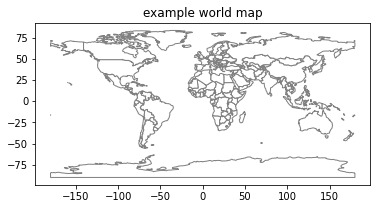

In [24]:
g = world.plot(color='white', edgecolor='gray')
g.set_title("example world map")

Now, we can overwrite the data on world map like following,

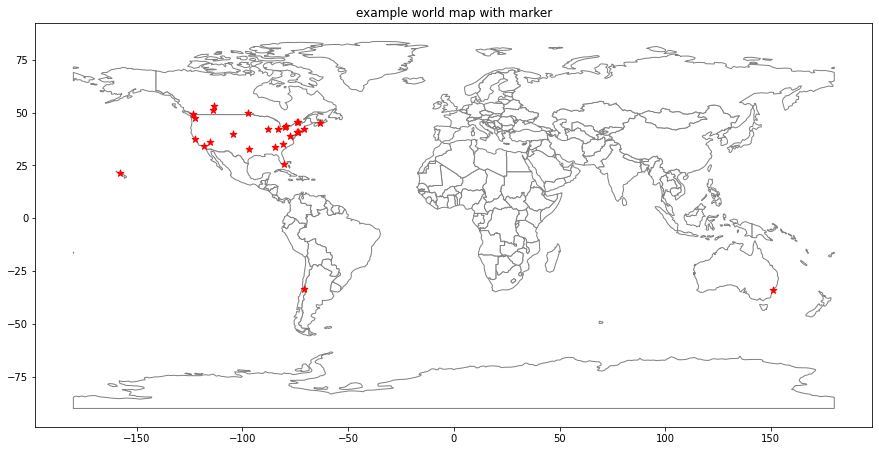

In [25]:
ax = world.plot(color='white', edgecolor='gray', figsize=(15, 10))
g = gdf.plot(ax=ax, marker='*', color='red', markersize=50)
g.set_title("example world map with marker")
plt.show()

Just like the map above, we were able to plot the location of the airport.

When we use plot(), if we pass column argment to it, we can easily create choropleth like maps. Of couase, add legend, we have to be a little more creative, though, as shown below.

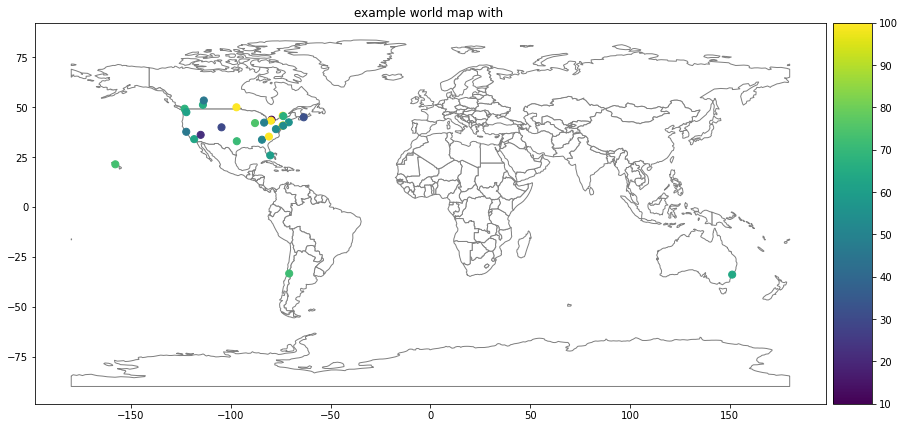

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = gdf.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("example world map with ")
plt.show()

covid_impact_on_airport_traffic_unique was a dataframe that I created appropriately so that the airport's information would be unique. So the map doesn't mean much.

Next, let's try to visualize it with meaningful data.

<a id="5"></a> <br>
# <div class="alert alert-block alert-info">Visualization with geopandas</div>

## Average per weekday

First, I'll average "PercentOfBaseline" across specified weekday.

The airport and day of the week are used as a composite key, averaged and combined with geographic data to create data to be visualized.

In [27]:
df_airport_weekday_mean = covid_impact_on_airport_traffic[["AirportName", "weekday", "PercentOfBaseline"]].groupby(["AirportName", "weekday"]).mean()
df_airport_weekday_mean = df_airport_weekday_mean.reset_index()
df_airport_weekday_mean = df_airport_weekday_mean.merge(df_geometry, on="AirportName")

In [28]:
df_airport_weekday_mean.head()

,AirportName,weekday,PercentOfBaseline,City,State,ISO_3166_2,Country,long,lat
0,Boston Logan International,Fri,63.567568,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
1,Boston Logan International,Mon,64.162162,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
2,Boston Logan International,Sat,62.432432,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
3,Boston Logan International,Sun,63.351351,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
4,Boston Logan International,Thu,61.432432,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633


I'll extract only on Sunday's data and create GeoDataFrame.

In [29]:
df_airport_weekday_mean_sun = df_airport_weekday_mean[df_airport_weekday_mean["weekday"]=="Sun"]
gdf_airport_weekday_mean_sun = gpd.GeoDataFrame(df_airport_weekday_mean_sun, 
                                                geometry=gpd.points_from_xy(df_airport_weekday_mean_sun.long, df_airport_weekday_mean_sun.lat))

Let's plot!

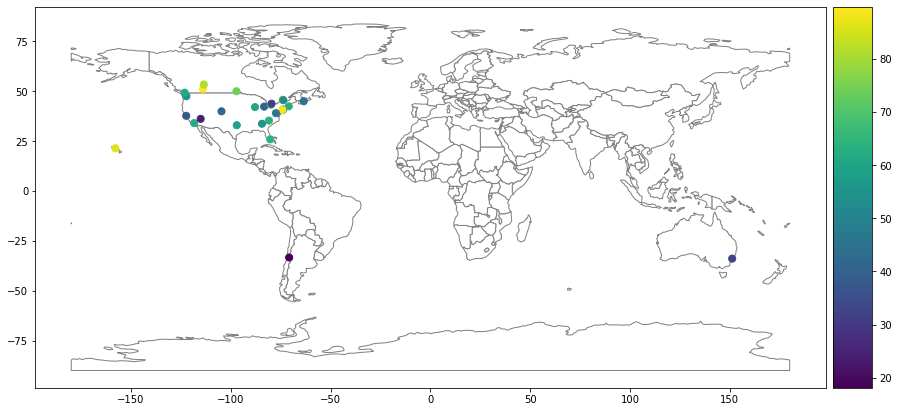

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_weekday_mean_sun.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()

And also I'll extract only on Wednesday's data , create GeoDataFrame and plot.

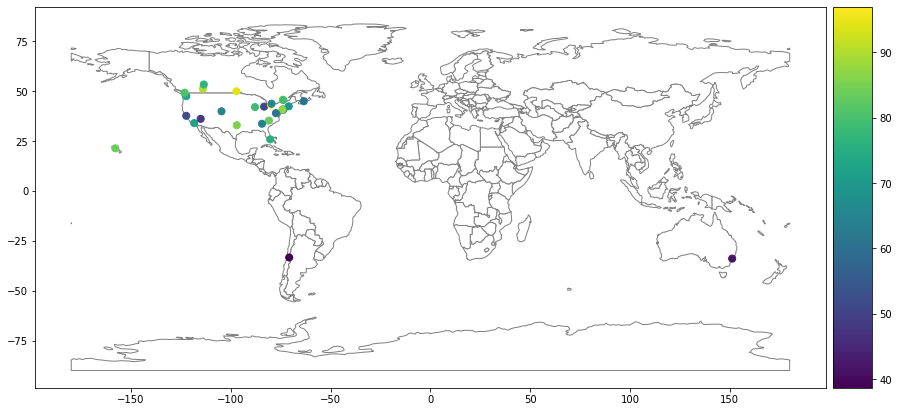

In [31]:
df_airport_weekday_mean_wed = df_airport_weekday_mean[df_airport_weekday_mean["weekday"]=="Wed"]
gdf_airport_weekday_mean_wed = gpd.GeoDataFrame(df_airport_weekday_mean_wed, 
                                                geometry=gpd.points_from_xy(df_airport_weekday_mean_wed.long, df_airport_weekday_mean_wed.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_weekday_mean_wed.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()

On Sunday, Hawaii's PercentOfBaseline is the highest, but on Wednesday, Winnipeg's value is the highest.

I don't know if it makes sense to look at averages for all weekdays, so I'll just leave it at that. If you have interest, please fork and try.

## Average per month

I also try to plot on specific month.

Just like the weekdays, I now create a table with the airport name and the month as a compound key.

In [32]:
df_airport_date_mean = covid_impact_on_airport_traffic[["AirportName", "Date", "PercentOfBaseline"]]
df_airport_date_mean["Date"] = df_airport_date_mean["Date"].map(lambda d: d.month)
df_airport_date_mean = df_airport_date_mean.groupby(["AirportName", "Date"]).mean()
df_airport_date_mean = df_airport_date_mean.reset_index()
df_airport_date_mean = df_airport_date_mean.merge(df_geometry, on="AirportName")
df_airport_date_mean = df_airport_date_mean.rename(columns={"Date": "month"})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I'll filter by month and visualize with geopandas.

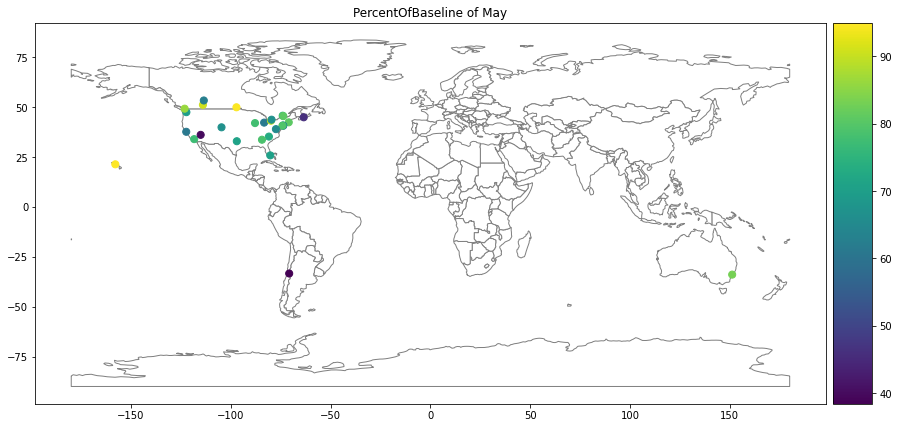

In [33]:
df_airport_date_mean_3 = df_airport_date_mean[df_airport_date_mean["month"]==3]
df_airport_date_mean_3 = gpd.GeoDataFrame(df_airport_date_mean_3, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_3.long, df_airport_date_mean_3.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_3.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of May")
plt.show()

We can find that Daniel K. Inouye International Airport in Hawaii is the highest, and Santiago International Airport is the lowest. 

Using the same method, I'll plot them in April and beyond.

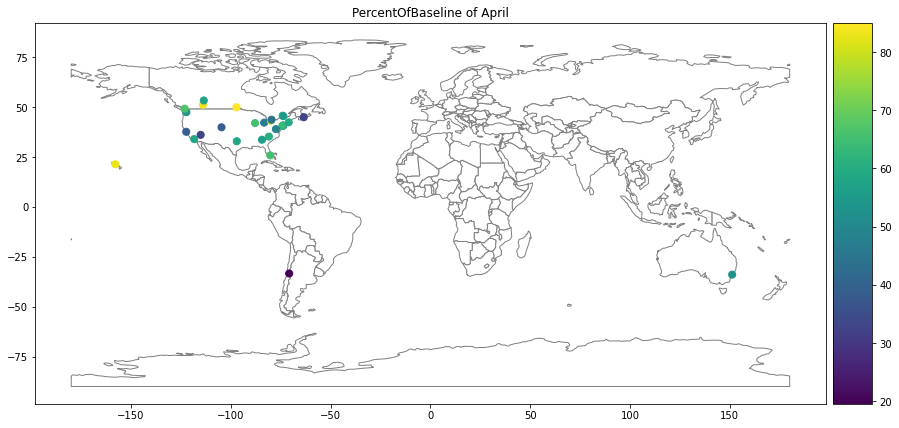

In [34]:
df_airport_date_mean_4 = df_airport_date_mean[df_airport_date_mean["month"]==4]
df_airport_date_mean_4 = gpd.GeoDataFrame(df_airport_date_mean_4, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_4.long, df_airport_date_mean_4.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_4.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of April")
plt.show()

Winnipeg International Airport is the highest, and Santiago International Airport is the lowest.

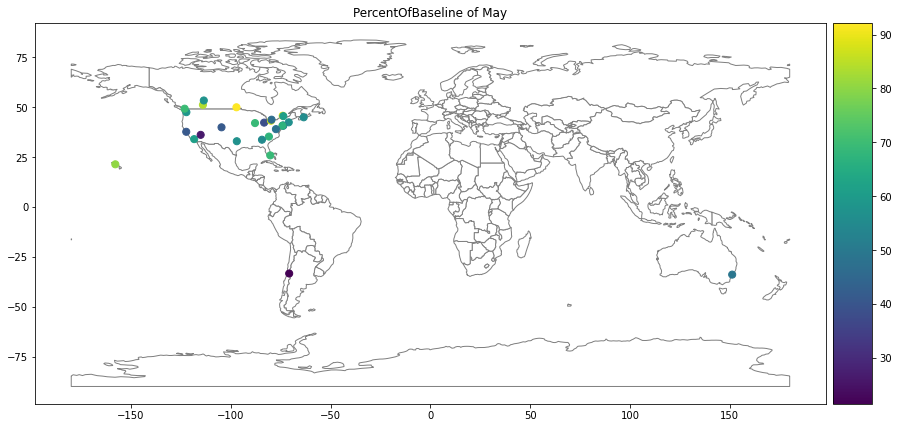

In [35]:
df_airport_date_mean_5 = df_airport_date_mean[df_airport_date_mean["month"]==5]
df_airport_date_mean_5 = gpd.GeoDataFrame(df_airport_date_mean_5, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_5.long, df_airport_date_mean_5.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_5.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of May")
plt.show()

Winnipeg International Airport is the highest, and Santiago International Airport is the lowest.

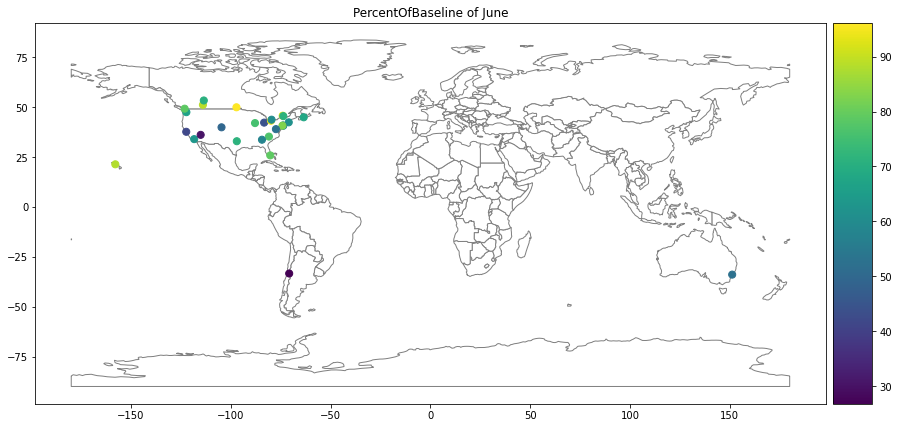

In [36]:
df_airport_date_mean_6 = df_airport_date_mean[df_airport_date_mean["month"]==6]
df_airport_date_mean_6 = gpd.GeoDataFrame(df_airport_date_mean_6, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_6.long, df_airport_date_mean_6.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_6.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of June")
plt.show()

Winnipeg International Airport is the highest, and Santiago International Airport is the lowest.

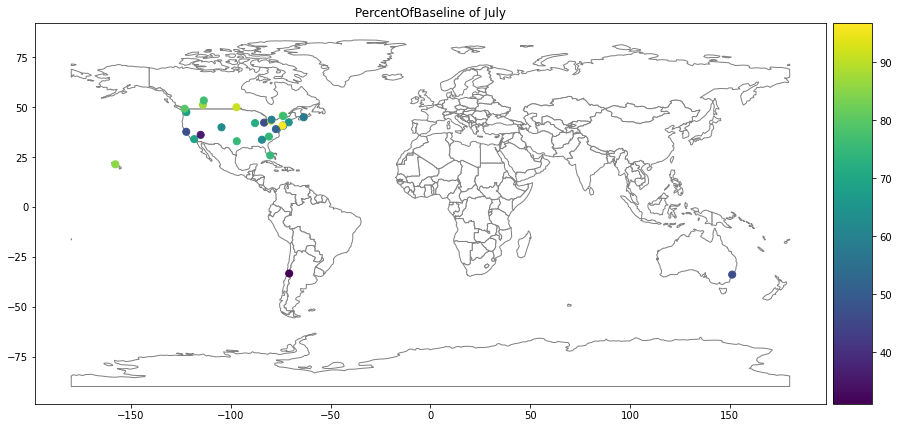

In [37]:
df_airport_date_mean_7 = df_airport_date_mean[df_airport_date_mean["month"]==7]
df_airport_date_mean_7 = gpd.GeoDataFrame(df_airport_date_mean_7, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_7.long, df_airport_date_mean_7.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_7.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of July")
plt.show()

Newark Liberty International Airport is the highest, and Santiago International Airport is the lowest.

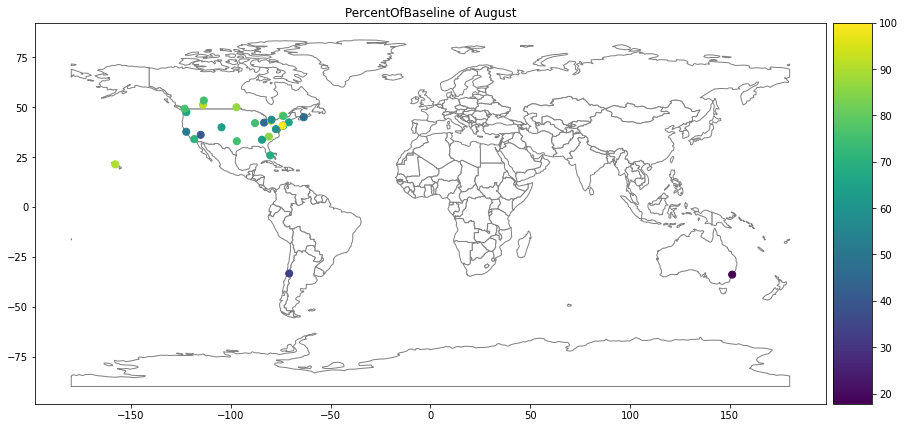

In [38]:
df_airport_date_mean_8 = df_airport_date_mean[df_airport_date_mean["month"]==8]
df_airport_date_mean_8 = gpd.GeoDataFrame(df_airport_date_mean_8, 
                                                geometry=gpd.points_from_xy(df_airport_date_mean_8.long, df_airport_date_mean_8.lat))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
g = df_airport_date_mean_8.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
g.set_title("PercentOfBaseline of August")
plt.show()

Newark Liberty International Airport is the highest, and Kingsford Smith Airport is the lowest.

<a id="6"></a> <br>
# <div class="alert alert-block alert-info">Visualization with plotly</div> 

Using scatter_mapbox function of Plotly express, we can also easily create interactive geographic plots.

So far, we have looked at detailed data by month and weekday, but here, for reasons to be discussed later, let's visualize the total data by airport name.

In [39]:
df_airport_date_all_mean = covid_impact_on_airport_traffic.groupby(["AirportName"]).mean()
df_airport_date_all_mean = df_airport_date_all_mean.reset_index()

In [40]:
df_airport_date_all_mean.head()

,AirportName,PercentOfBaseline,long,lat
0,Boston Logan International,64.704981,-71.010291,42.363633
1,Calgary International,89.513410,-114.013123,51.118475
2,Charlotte Douglas International,75.375479,-80.947811,35.213689
3,Chicago OHare International,73.084291,-87.910595,41.980460
4,Dallas/Fort Worth International,75.293893,-97.039498,32.894059


For example, we can visualize the following

In [41]:
fig = px.scatter_mapbox(df_airport_date_all_mean,
                        lat="lat",
                        lon="long",
                        hover_name="AirportName",
                        hover_data=["PercentOfBaseline"],
                        color="PercentOfBaseline",
                        zoom=1,
                        height=600,
                        size="PercentOfBaseline",
                        size_max=30,
                        opacity=0.4,
                        width=1300)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="Mean of trafic on sunday")
fig.show()

By specifying lat and lon, we can specify the position of the markers, and by specifying color and size, we can change the color and size of the marker to match the size of the data. Also, by setting mapbox_style to 'stimen-terrain', it is possible to depict data on a map that shows geographic features in color.

We can find that Hamilton International Airport has highest, and Santiago International Airport is the lowest. Unlike geopandas plots, this is an interactive plot, so we can also hover the cursor over a point to get a specific value.

If we use "carto-positron" for mapbox_style, we can create more simple geographical visualization.

In [42]:
fig = px.scatter_mapbox(df_airport_date_all_mean,
                        lat="lat",
                        lon="long",
                        hover_name="AirportName",
                        hover_data=["PercentOfBaseline"],
                        color="PercentOfBaseline",
                        zoom=1,
                        height=600,
                        size="PercentOfBaseline",
                        size_max=30,
                        opacity=0.4,
                        width=1300)
fig.update_layout(mapbox_style='carto-positron')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="Mean of trafic on sunday")
fig.show()

At first glance, Plotly looks better, but　I also found out that it's not all good.

For example, if you create a large number of plots, some plots will become impossible to display. In this theme, we want to visualize geographic data in a time series. Therefore, we need to display a large number of plots.

Also, if you plot a large amount of data, it will take a long time to load when you save and view it from a browser.

But scatter_mapbox is very useful and powerful function for geographical visualization. I don't think there are many ways to display geographic data in such an interactive and attractive way, even among kagglers. We should use it actively. 

For another example of scatter_mapbox function of Plotly express, you can cehck [Analyzing Geospatial Environmental Data using Plotly Express and GeoPandas](https://medium.com/analytics-vidhya/analyzing-geospatial-enviromental-data-using-plotly-and-geopandas-c568eba96ac6).

<a id="7"></a> <br>
# <div class="alert alert-block alert-warning">Appendix</div>

As a reference for visualization of geographic data, I have also included a visualization method using geoplot. I will organize this notebook to make them a bit more clear in a later release.

<a id="8"></a> <br>
## <div class="alert alert-block alert-success">How to draw airports shape on map</div>

I wanted to plot Poligon data in "Geography" column, so I tried.

In order to plot by geoplot, we will change the column name and also convert data from a string to a polygon instance.

In [43]:
gdf = gdf[[col for col in gdf.columns if col not in ["geometry"]]]
gdf = gdf.rename(columns={'Geography': 'geometry'})

In [44]:
def polygon_str2polygon(polygon_str):
    coodinates = re.split("[, ]", polygon_str[9:-2])
    coodinates = [float(item) for item in coodinates if item != ""]
    return Polygon([coodinates[i:i+2] for i in range(0,len(coodinates),2)])
    
gdf["geometry"] = gdf["geometry"].map(polygon_str2polygon)

Let's take a look at the data for New York.

In [45]:
gdf_newyork = gdf[gdf["City"].isin(["New York"])]
gdf_newyork = gpd.GeoDataFrame(gdf_newyork)
gdf_newyork

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,geometry,weekday,long,lat
23,2020-03-16,LaGuardia,95,New York,New York,US-NY,United States of America (the),"POLYGON ((-73.88763 40.76728, -73.88683 40.767...",Mon,-73.873246,40.773883
24,2020-05-26,John F. Kennedy International,53,New York,New York,US-NY,United States of America (the),"POLYGON ((-73.78840 40.62270, -73.78494 40.621...",Tue,-73.778447,40.646027


We can view the shape of polygon instances.

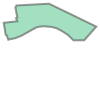

In [46]:
gdf_newyork.iloc[0]["geometry"]

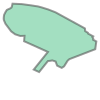

In [47]:
gdf_newyork.iloc[1]["geometry"]

We will also get a map of New York State that will serve as a background for depicting the two shapes above.

In [48]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
newyork_shape = contiguous_usa[contiguous_usa["state"].isin(["New York"])]
newyork_shape

,state,adm1_code,population,geometry
45,New York,USA-3559,19378102,"POLYGON ((-74.67903 41.35549, -74.84044 41.426..."


Text(0.5, 1.0, 'New York')

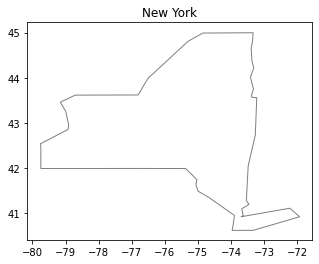

In [49]:
g = newyork_shape.plot(color='white', edgecolor='gray')
g.set_title("New York")

Now let's draw shapes of airports over the state of New York.

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:627: UserWarning:

Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.



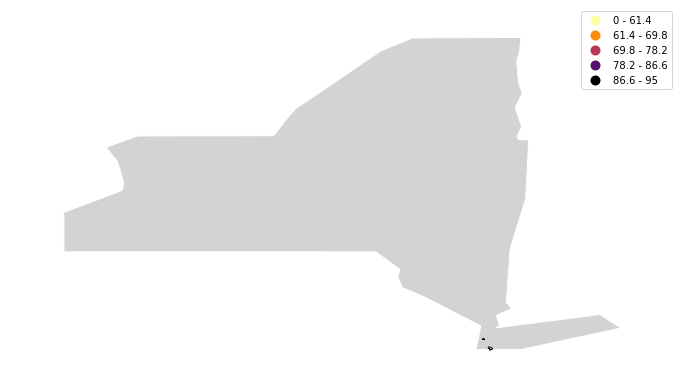

In [50]:
gpd_per_person = gdf_newyork["PercentOfBaseline"]
scheme = mapclassify.Quantiles(gpd_per_person, k=5)

base1 = gplt.choropleth(
    gdf_newyork, #ax=base,
    hue=gpd_per_person, scheme=scheme,
    cmap='inferno_r', legend=True, figsize=(12, 12)
)

gplt.polyplot(
    newyork_shape, ax=base1,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(12, 12)
)

<div class="alert alert-block alert-warning">↑too little...</div>


The map can also be reversed by swapping the plots passed to ax.

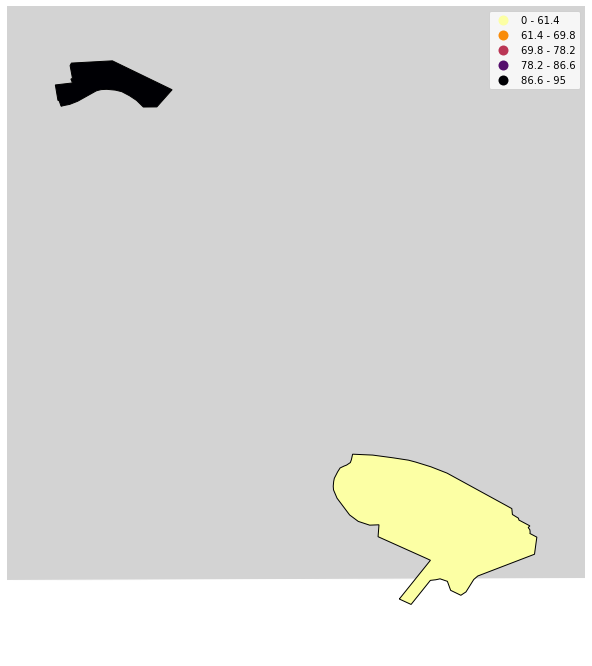

In [51]:
gpd_per_person = gdf_newyork["PercentOfBaseline"]
scheme = mapclassify.Quantiles(gpd_per_person, k=5)

base2 = gplt.polyplot(
    newyork_shape,
    edgecolor='white',
    facecolor='lightgray',
    figsize=(12, 12)
)
gplt.choropleth(
    gdf_newyork, ax=base2,
    hue=gpd_per_person, scheme=scheme,
    cmap='inferno_r', legend=True, figsize=(12, 12)
)

<a id="9"></a> <br>
## <div class="alert alert-block alert-success">Plot with pointplot of geoplot</div>

we can also plot pointplot by geoplot. We have to pass geopandas dataframe which has Point instance for geometry column.

In [52]:
def create_point_geom(data):
    x = data[0]
    y = data[1]
    point = Point(x, y)
    return point

In [53]:
gdf["geometry"] = gdf[["long", "lat"]].apply(create_point_geom, axis=1)

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:258: UserWarning:

Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".



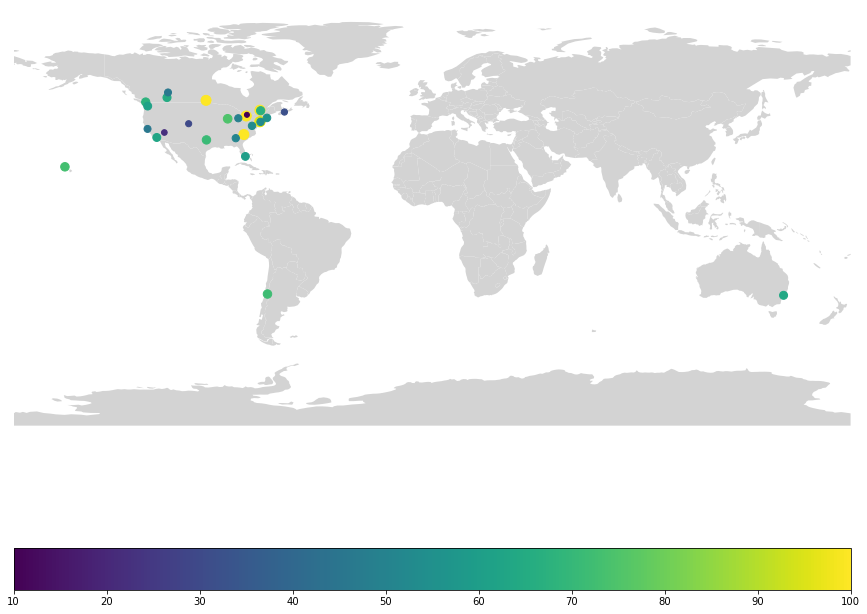

In [54]:
ax = gplt.pointplot(
    gpd.GeoDataFrame(gdf),
    legend_kwargs={'orientation': 'horizontal'}, scale='PercentOfBaseline',limits=(5, 10),
    hue='PercentOfBaseline', legend=True, figsize=(15, 15)
)
gplt.polyplot(
    world, ax=ax, 
    edgecolor='None', facecolor='lightgray'
)